# Examine single-cell mAP scores after normalization steps
**Author:** Jessica Ewald <br>

The purpose of this script is to compare single-cell-level mAP results after each step in the pipeline, with the goal of determining which steps are improving detection of biological signal. There are three normalization steps (well position correction, cell count regression, and robustMAD) and three filtering steps (variance/NA threshold, noise removal, and correlation threshold). mAP is computed on the annotated data prior to any processing, and after each normalization and filtering step. 

Since it is not computationally feasible to compute mAP for the entire single cell dataset, filtering and sampling is conducted at multiple levels. First, all positive, negative, and transcription controls are filtered out. Second, 5 cells are sampled per well. Third, inside of the mAP function, negative pairs are sampled such that there are approximately 10 negative pairs for every positive pair. This greatly reduces the total number of pairs because the there are exponentially more negative pairs than positive pairs due to the experimental design. 

In [12]:
# Imports
import pathlib
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multi
import seaborn as sns
from random import sample

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [13]:
# Define all paths and files
map_data_dir = pathlib.Path("/dgx1nas1/storage/data/jess/varchamp/sc_data/map_data/").resolve(strict=True)
bl_path = pathlib.Path(f'{map_data_dir}/bl_map_data.parquet')
well_path = pathlib.Path(f'{map_data_dir}/well_map_data.parquet')
norm_path = pathlib.Path(f'{map_data_dir}/norm_map_data.parquet')
cc_path = pathlib.Path(f'{map_data_dir}/cc_map_data.parquet')

First, we read in data files corresponding to the different processing steps and plot a histogram of mAP scores for each one.

In [21]:
# Read in data
bl = pl.read_parquet(bl_path)
well = pl.read_parquet(well_path)
norm = pl.read_parquet(norm_path)
#cc = pl.read_parquet(cc_path)

feat_col = [i for i in bl.columns if "Metadata_" not in i] 
feat_col = [i for i in feat_col if i not in ['n_pos_pairs', 'n_total_pairs', 'average_precision']]

# Initialize results dataframe
schema = [
    ("Feature", pl.Utf8),
    ("Coefficient", pl.Float64),
    ("P-value", pl.Float64)
]

# Function to fit OLS model and extract coefficient and p-value
def fit_ols(x, y, df):
    model = ols(f'{y} ~ {x}', data = df).fit()
    return pl.DataFrame({'Feature': y, 'Coefficient': model.params[x], 'P-value': model.pvalues[x]})

Text(0.5, 1.0, 'AP after MAD normalization')

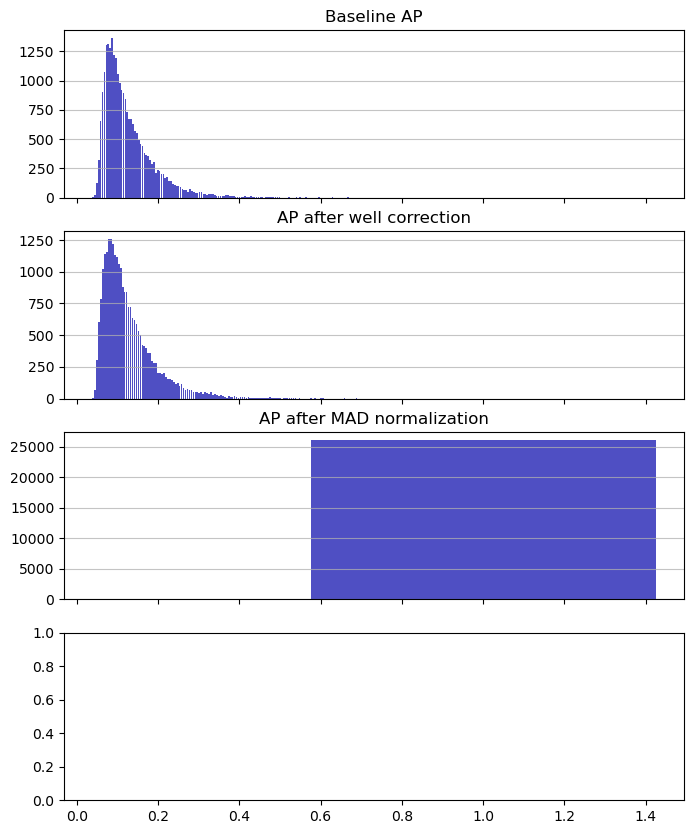

In [22]:
# Make histograms
fig, axs = plt.subplots(4, sharex=True, figsize=(8, 10))

# make bl histogram
n, bins, patches = axs[0].hist(x=bl["average_precision"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[0].grid(axis='y', alpha=0.75)
axs[0].set_title('Baseline AP')

# make well-corrected histogram
n, bins, patches = axs[1].hist(x=well["average_precision"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[1].grid(axis='y', alpha=0.75)
axs[1].set_title('AP after well correction')

# make mad normalized histogram
n, bins, patches = axs[2].hist(x=norm["average_precision"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[2].grid(axis='y', alpha=0.75)
axs[2].set_title('AP after MAD normalization')

# # make cc corrected histogram
# n, bins, patches = axs[3].hist(x=cc["average_precision"], bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# axs[3].grid(axis='y', alpha=0.75)
# axs[3].set_title('AP after cell count correction')


There are a strange subset of cells with a mAP of exactly 1 for the baseline and well position corrected data. The distribution of other mAP scores appears to shift ever-so-slightly to the right after well position correction. After MAD normalization, all mAP scores are 1, and this persists after cell count correction (doing cell count correction and then MAD normalization was also tried - the results were the same). 

This raises two questions:
1. What is "special" about the cells with a mAP of 1 in the first two plots?
2. What are the latter two steps doing that causes all mAP scores to go to 1?

Start with question #1 and look at just the baseline data.

In [6]:
result_df = pl.DataFrame([], schema=schema)

for feature_column in feat_col:
    result_df = pl.concat([result_df, fit_ols("average_precision", feature_column, bl)])

result_df = result_df.sort('P-value')


Text(0, 0.5, 'Cells_Correlation_Costes_DNA_AGP')

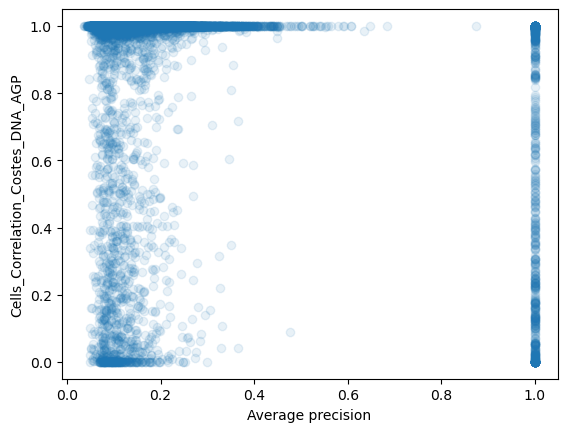

In [7]:
plot_feat = result_df['Feature'][10]

# code from online
plt.scatter(bl['average_precision'], bl[plot_feat], alpha=0.1)
plt.xlabel("Average precision")
plt.ylabel(plot_feat)



There are many features that have a statistically significant relationship with average precision, but scatterplots of the top few show that there isn't a clear difference between cells with an average precision of 1 and the others. We can re-do the linear model to directly compare the cells with average precision equals 1 to all other cells. 

In [5]:
# Define list indicating whether ap is equal to 1 or not
bl = bl.with_columns((pl.col("average_precision") == 1).cast(pl.Utf8).alias("ap_category"))
dummy = pl.Series(bl["ap_category"]).to_dummies().to_series(1)

# add to dataframe
bl = bl.with_columns(dummy)
bl = bl.rename({dummy.name : "ap_dummy"})


In [9]:

# fit model to each feature
result_cat = pl.DataFrame([], schema=schema)

for feature_column in feat_col:
    result_cat = pl.concat([result_cat, fit_ols("ap_dummy", feature_column, bl)])

fdr = multi.fdrcorrection(result_cat["P-value"])[1]
result_cat = result_cat.with_columns(pl.Series("FDR", fdr))
result_cat = result_cat.sort('P-value')

print(result_cat)


shape: (3_193, 4)
┌───────────────────────────────────┬─────────────┬─────────────┬─────┐
│ Feature                           ┆ Coefficient ┆ P-value     ┆ FDR │
│ ---                               ┆ ---         ┆ ---         ┆ --- │
│ str                               ┆ f64         ┆ f64         ┆ f64 │
╞═══════════════════════════════════╪═════════════╪═════════════╪═════╡
│ Cells_Children_Cytoplasm_Count    ┆ 3.7181e-15  ┆ 0.0         ┆ NaN │
│ Nuclei_Children_Cells_Count       ┆ 3.7181e-15  ┆ 0.0         ┆ NaN │
│ Nuclei_Children_Cytoplasm_Count   ┆ 3.7181e-15  ┆ 0.0         ┆ NaN │
│ Nuclei_Correlation_Costes_AGP_DN… ┆ -0.069029   ┆ 1.2029e-172 ┆ NaN │
│ Cells_Correlation_Costes_DNA_GFP  ┆ -0.101221   ┆ 1.3740e-120 ┆ NaN │
│ …                                 ┆ …           ┆ …           ┆ …   │
│ Nuclei_Location_Center_Z          ┆ 0.0         ┆ NaN         ┆ NaN │
│ Nuclei_Location_MaxIntensity_Z_A… ┆ 0.0         ┆ NaN         ┆ NaN │
│ Nuclei_Location_MaxIntensity_Z_D… ┆ 0.0     

<Axes: xlabel='ap_category', ylabel='Nuclei_Correlation_Costes_AGP_DNA'>

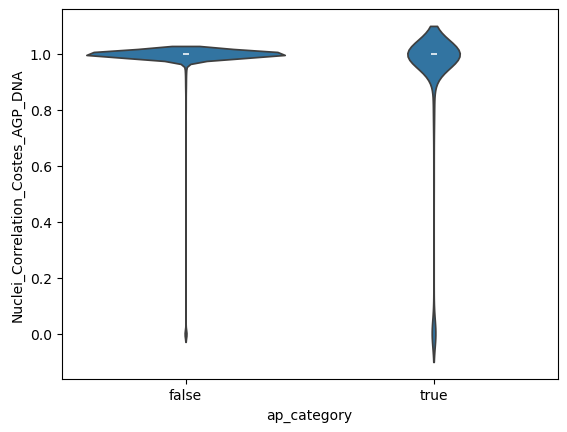

In [10]:
# Examine a few of the top features
plot_feat = result_cat["Feature"][3]
sns.violinplot(data = bl.to_pandas(), x = 'ap_category', y = plot_feat)


There still isn't a clear global signature for cells that have high mAP scores, but it's possible that these differences will be more obvious if the well position and plate is taken into consideration. First, try by subsetting a single plate. 

In [6]:
# Just grab the first plate - already checked that the mAP = 1 are fairly evenly distributed across all plates
plates = bl.get_column("Metadata_batch_Plate").to_list()
plates = np.unique(plates)

# use T# to get one replicate from each allele set; use P# to get all techincal reps of one platemap
allele_set = [x for x in plates if "P4" in x]

#bl_plate = bl.filter(pl.col("Metadata_batch_Plate").is_in(allele_set))
bl_plate = bl.filter(pl.col("Metadata_batch_Plate") == plates[4])


In [12]:

# fit model to each feature
result_plate = pl.DataFrame([], schema=schema)

for feature_column in feat_col:
    result_plate = pl.concat([result_plate, fit_ols("ap_dummy", feature_column, bl_plate)])

fdr = multi.fdrcorrection(result_plate["P-value"])[1]
result_plate = result_plate.with_columns(pl.Series("FDR", fdr))
result_plate = result_plate.sort('P-value')

print(result_plate)



shape: (3_193, 4)
┌───────────────────────────────────┬──────────────┬────────────┬─────┐
│ Feature                           ┆ Coefficient  ┆ P-value    ┆ FDR │
│ ---                               ┆ ---          ┆ ---        ┆ --- │
│ str                               ┆ f64          ┆ f64        ┆ f64 │
╞═══════════════════════════════════╪══════════════╪════════════╪═════╡
│ Nuclei_ObjectSkeleton_TotalObjec… ┆ 10217.516044 ┆ 1.9757e-12 ┆ NaN │
│ Nuclei_ObjectSkeleton_NumberNonT… ┆ 1210.099882  ┆ 2.2960e-12 ┆ NaN │
│ Cytoplasm_Texture_Entropy_Mito_1… ┆ -0.807205    ┆ 7.7960e-10 ┆ NaN │
│ Cells_Intensity_MedianIntensity_… ┆ 0.000691     ┆ 9.2990e-10 ┆ NaN │
│ Nuclei_Correlation_K_Mito_AGP     ┆ 0.267164     ┆ 1.3331e-9  ┆ NaN │
│ …                                 ┆ …            ┆ …          ┆ …   │
│ Nuclei_Location_Center_Z          ┆ 0.0          ┆ NaN        ┆ NaN │
│ Nuclei_Location_MaxIntensity_Z_A… ┆ 0.0          ┆ NaN        ┆ NaN │
│ Nuclei_Location_MaxIntensity_Z_D… ┆ 0.0     

<Axes: xlabel='ap_category', ylabel='Nuclei_Correlation_K_Mito_AGP'>

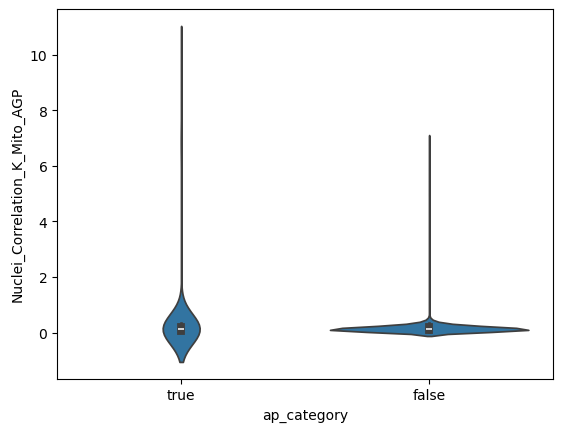

In [13]:
# Examine a few of the top features
plot_feat = result_plate["Feature"][4]
sns.violinplot(data = bl_plate.to_pandas(), x = 'ap_category', y = plot_feat)

A feature-centered analysis is not giving clear insights. Next, try look at distributions of all features within cells that have a mAP of 1 versus other cells. 

Cells with relatively high number of NaNs:  159
152
46


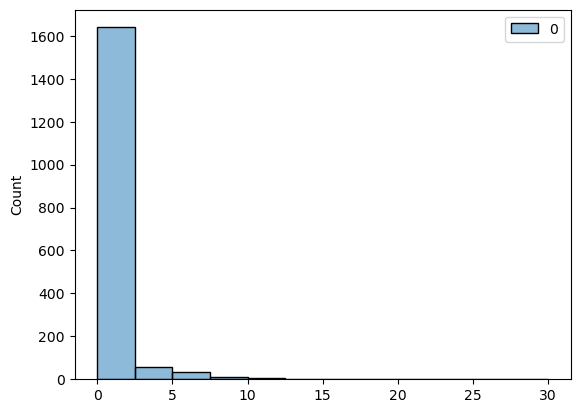

In [11]:
bl_plate_feats = bl_plate.select(feat_col)

bl_cells = bl_plate_feats.transpose(column_names=bl_plate["Metadata_CellID"])

# compute, plot, and summarize the number of NaN features for each cell
num_nan = bl_cells.select(pl.all().is_null().sum()).transpose()

nd_cells = bl_plate.select(feat_col).to_numpy()
nan_mask = np.isnan(nd_cells)
nan_per_cell = np.sum(nan_mask, axis=1).reshape(-1, 1) 


sns.histplot(nan_per_cell)
print(f"Cells with relatively high number of NaNs:  {sum(num_nan.get_column(num_nan.columns[0]).to_numpy() > 0)}")

print(sum(bl_plate.get_column("average_precision").to_numpy() == 1))
print(sum((num_nan.get_column(num_nan.columns[0]).to_numpy() > 0) & (bl_plate.get_column("average_precision").to_numpy() == 1)))

In [8]:
bl_cells.shape



(3193, 1751)

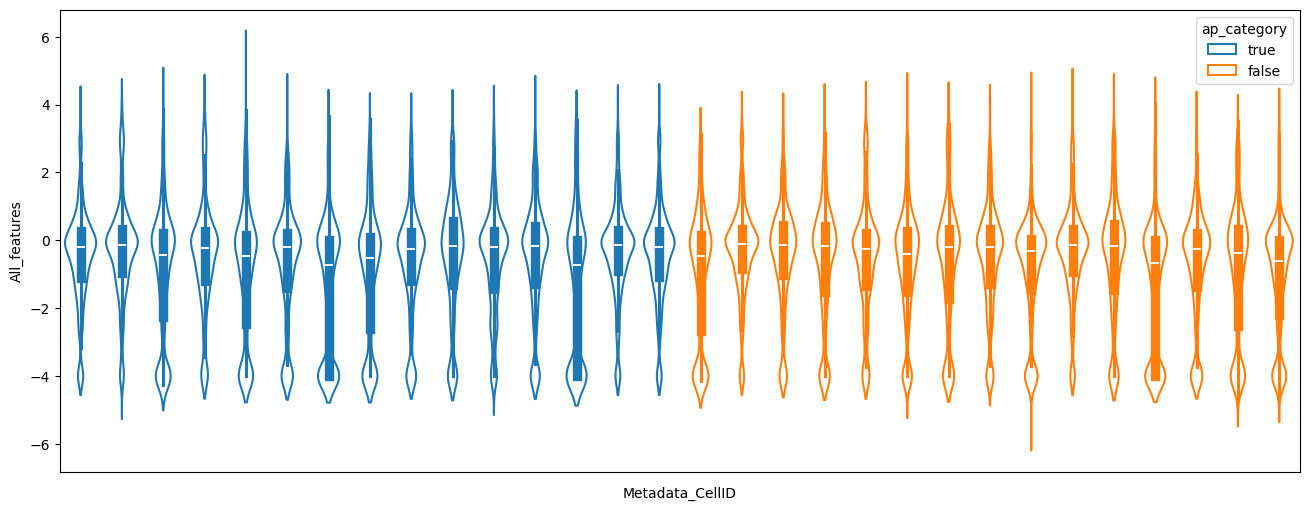

In [200]:
# look at the distribution of all features within cells
# log10 transformation for viz purposes
cells_log10 = bl_cells.select(pl.all().add(0.0001).log10())

weird_cells = bl_plate.filter(pl.col("average_precision") == 1).get_column("Metadata_CellID").to_numpy()
normal_cells = bl_plate.filter(pl.col("average_precision") < 1).get_column("Metadata_CellID").to_numpy()

# take 15 randomly from each category
cells = np.concatenate((sample(list(weird_cells), 15), sample(list(normal_cells), 15)))

def plot_cell_dist(cells, df, grp):
    df = df.select(cells)

    df = df.melt(variable_name="Metadata_CellID", value_name="All_features")
    df = df.join(bl_plate.select(['Metadata_CellID', grp]), on = "Metadata_CellID")

    plt.figure(figsize=(16, 6))
    vp = sns.violinplot(
        data = df.to_pandas(), 
        x = 'Metadata_CellID', 
        y = 'All_features', 
        hue = grp, 
        fill = False
    )
    vp.set(xticklabels = [])
    vp.tick_params(bottom=False)
    plt.show()

plot_cell_dist(cells, cells_log10, 'ap_category')




At first, it looked like there was a clear pattern between the cell profiles with and without average precision equal to one, however I realized that I was selecting the first 15 ap_one cells and the first 15 ap_other cells. Since there are only 1 or 2 ap_one per plate/well position, but many more ap_other, the ap_other were all from the same or similar location. After switching to randomly sampling 15 from each group, the clear difference disappeared. 

This makes me realize that whole feature distributions are quite different across different locations. Need to do more digging to see if these differences are driven by well, plate, or allele. Assessing allele will be difficult because there is usually only one location per plate. There are multiple controls per plate, but these need to be accessed independently because they were filtered out prior to computing mAP. 

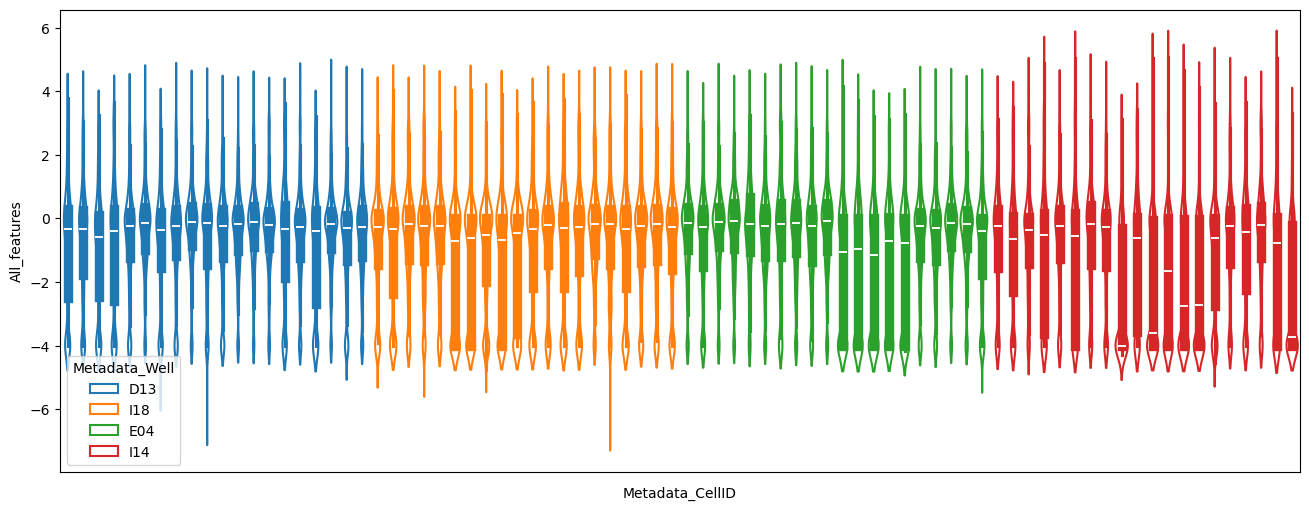

In [201]:
# plot distributions from random well positions
all_wells = bl_plate.get_column("Metadata_Well").to_list()
all_wells = np.unique(all_wells)

sel_wells = sample(list(all_wells), 4)
cells = []
for well in sel_wells:
    temp = bl_plate.filter(pl.col("Metadata_Well") == well).get_column("Metadata_CellID").to_numpy()
    cells = np.concatenate((list(cells), list(temp)))

plot_cell_dist(cells, cells_log10, 'Metadata_Well')

No clear visible distinction, but also there are only 5 cells per well in the sampled data so not surprising. Was looking for massive, clear differences that could explain this. Next, try PCA and UMAP and color points by whether the cells have mAP of 1 or not. 

In [202]:
# prepare data for dimension reduction

from sklearn.preprocessing import StandardScaler

# get the names of all feature columns that contain NA values
col_nas = pl.DataFrame(
    {
        "col_name": [c.name for c in bl_plate_feats.iter_columns()],
        "num_null": [c.is_null().sum() for c in bl_plate_feats.iter_columns()]
    }
).filter(pl.col("num_null") > 0).get_column("col_name").to_list()

# drop feature columns that contain null/NA values
dim_dat = bl_plate.drop(col_nas)

sel_col = [x for x in feat_col if x not in col_nas]

# separate into metadata and features
dim_meta = dim_dat.select(['Metadata_CellID', 'Metadata_Well', 'ap_category', 'average_precision', "Metadata_Symbol", "Metadata_allele"]).to_pandas()
dim_feats = dim_dat.select(sel_col).to_pandas()

# scale feature data
dim_feats = StandardScaler().fit_transform(dim_feats)


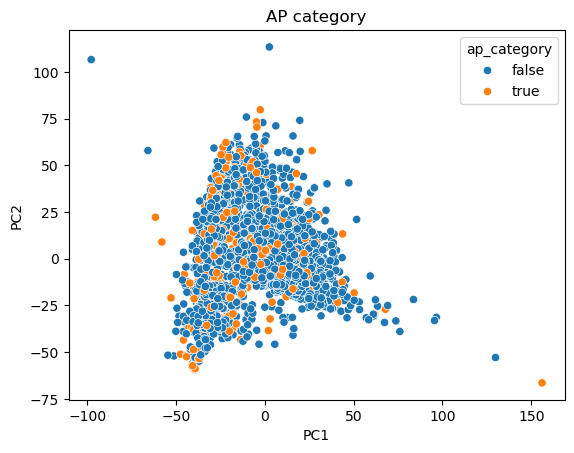

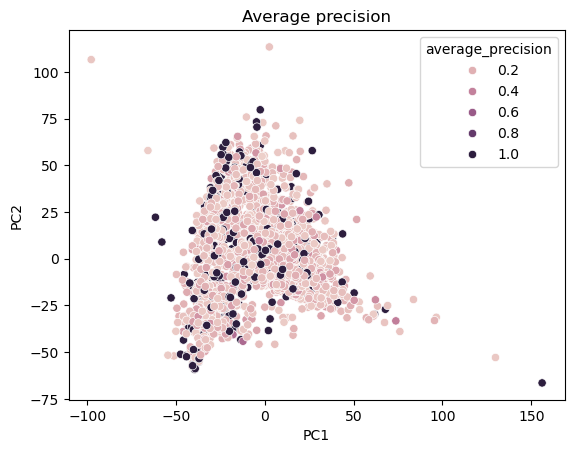

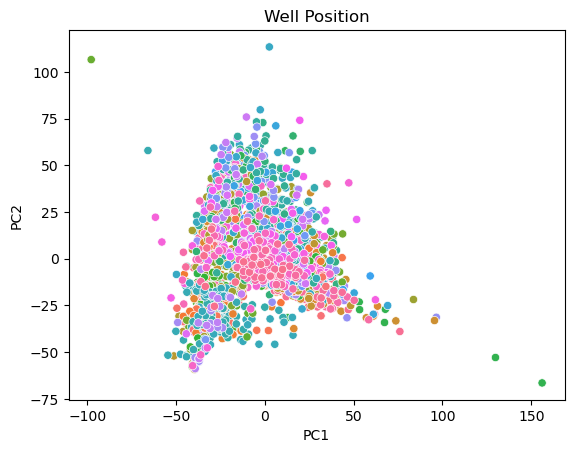

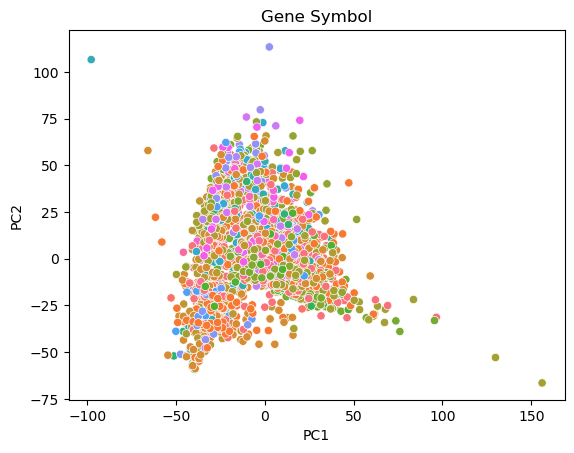

In [203]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pcs = pca.fit_transform(dim_feats)

# w/out scaling was 0.44, 0.40, after scaling was 0.15, 0.10
# print(pca.explained_variance_ratio_)

# add metadata of interest
pc_df = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2'])
pc_df = pd.concat([pc_df, dim_meta], axis = 1)

# plot with color according to different metadata
sns.scatterplot(data = pc_df, x = 'PC1', y = 'PC2', hue = 'ap_category')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('AP category')
plt.show()

sns.scatterplot(data = pc_df, x = 'PC1', y = 'PC2', hue = 'average_precision')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Average precision')
plt.show()

sns.scatterplot(data = pc_df, x = 'PC1', y = 'PC2', hue = 'Metadata_Well', legend = False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Well Position")
plt.show()

sns.scatterplot(data = pc_df, x = 'PC1', y = 'PC2', hue = 'Metadata_Symbol', legend = False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Gene Symbol")
plt.show()



Average precision (either category or actual values) is not explained by the top two PCs. Well position does appear somewhat in the top two PCs. Gene symbol also has some associated patterns. Next, try UMAP.

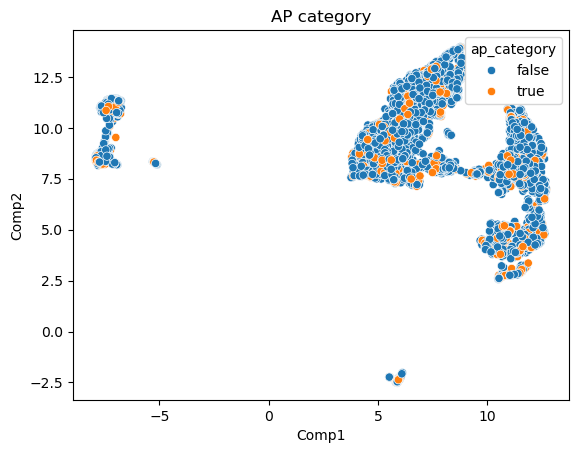

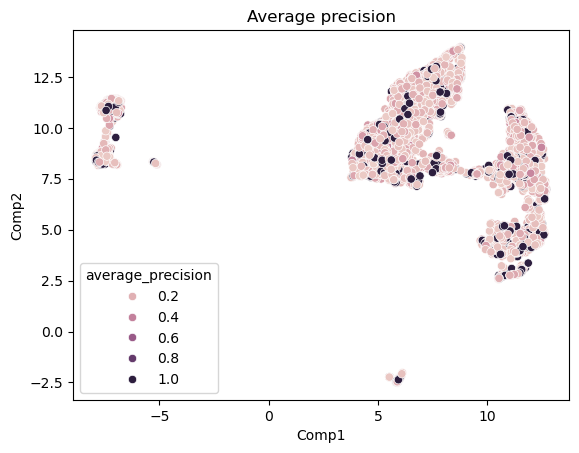

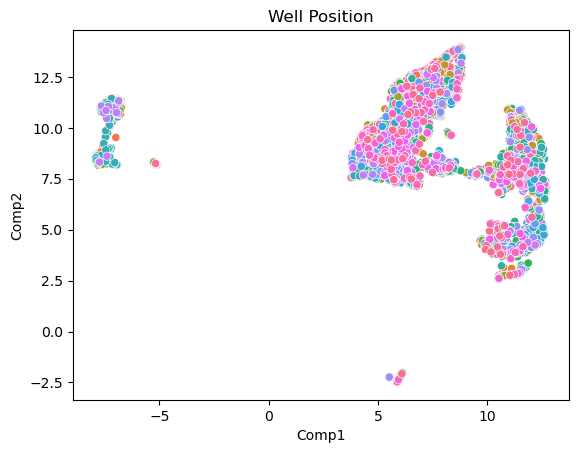

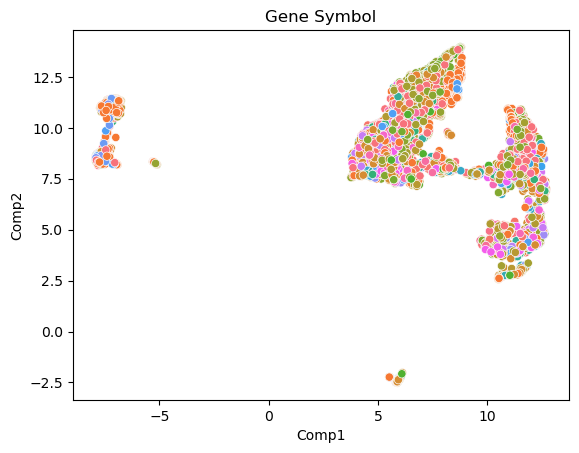

In [204]:
import umap.umap_ as umap

# compute umap
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(dim_feats)

umap_df = pd.DataFrame(embedding, columns = ['Comp1', 'Comp2'])
umap_df = pd.concat([umap_df, dim_meta], axis = 1)

# plot with color according to different metadata
sns.scatterplot(data = umap_df, x = 'Comp1', y = 'Comp2', hue = 'ap_category')
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.title('AP category')
plt.show()

sns.scatterplot(data = umap_df, x = 'Comp1', y = 'Comp2', hue = 'average_precision')
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.title('Average precision')
plt.show()

sns.scatterplot(data = umap_df, x = 'Comp1', y = 'Comp2', hue = 'Metadata_Well', legend = False)
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.title("Well Position")
plt.show()

sns.scatterplot(data = umap_df, x = 'Comp1', y = 'Comp2', hue = 'Metadata_Symbol', legend = False)
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.title("Gene Symbol")
plt.show()

The UMAP clusters in the top right are very intriguing. This is all from one plate, so not plate effect. The points are somewhat influenced but not perfectly explained by either well position or allele. My hypothesis is something cool like cell cycle, but maybe there is another technical factor that I'm not considering. Below I will develop plots that allow you to annotate cells corresponding to a particular gene symbol by allele. 

First - make a frequency table to get a rough sense of how many genetic perturbations there are per gene symbol. 

In [205]:
symbols = np.unique(umap_df['Metadata_Symbol'])

unique, counts = np.unique(umap_df['Metadata_Symbol'], return_counts=True)
print(np.asarray((unique, counts)).T)


[['SGCA' 20]
 ['SH2D1A' 20]
 ['SH3BP2' 138]
 ['SHMT1' 20]
 ['SIX1' 60]
 ['SLC22A5' 20]
 ['SLC6A20' 20]
 ['SLC9A3R1' 20]
 ['SMAD1' 40]
 ['SMAD3' 780]
 ['SMARCB1' 40]
 ['SMN2' 40]
 ['SNIP1' 79]
 ['SOX10' 20]
 ['SPG7' 20]
 ['SQSTM1' 20]
 ['SS18L1' 20]
 ['STAC3' 39]
 ['STAR' 100]
 ['STRA6' 20]
 ['STXBP1' 700]
 ['SUCLA2' 40]
 ['SUFU' 20]
 ['SUOX' 60]
 ['TACSTD2' 20]
 ['TAT' 100]
 ['TCAP' 20]
 ['TEAD1' 20]
 ['TFG' 20]
 ['TGFB1' 20]
 ['TGFBI' 20]
 ['TH' 599]
 ['THAP1' 120]
 ['TIMM8A' 20]
 ['TMEM43' 158]
 ['TNFAIP3' 20]
 ['TNFRSF13B' 20]
 ['TPK1' 40]
 ['TPM1' 439]
 ['TPM3' 40]
 ['TRAF3' 40]
 ['TREX1' 20]
 ['TRIB3' 20]
 ['TRIM2' 20]
 ['TRIM32' 20]
 ['TSFM' 20]
 ['TTPA' 160]
 ['TTR' 80]
 ['TUFM' 60]
 ['UBE3A' 20]
 ['UBQLN2' 114]
 ['UNC119' 40]
 ['UROD' 40]
 ['VAPB' 20]
 ['VPS33B' 20]
 ['WDR5' 20]
 ['WRAP53' 60]
 ['XPA' 40]
 ['XRCC2' 40]
 ['ZCCHC12' 20]
 ['ZMYND10' 60]
 ['ZNF24' 20]
 ['ZNF624' 20]]


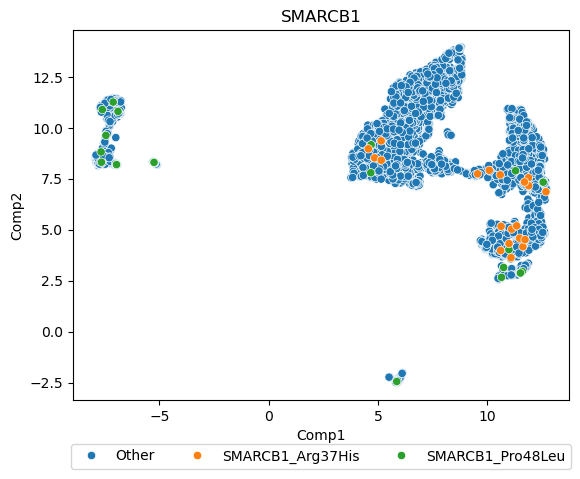

In [206]:
#plot_symbol = symbols[20]
plot_symbol = 'SMARCB1'

umap_df['Is_Allele'] = np.where(umap_df['Metadata_Symbol'] == plot_symbol, 'Yes', 'No')

umap_df['Allele'] = umap_df.apply(lambda row: row['Metadata_allele'] if row['Is_Allele'] == 'Yes' else 'Other', axis = 1)


umap_df = umap_df.sort_values('Is_Allele') # sort to plot symbol points on top
n_allele = len(umap_df['Allele'].unique())

if n_allele < 6:
    sns.scatterplot(data = umap_df, x = 'Comp1', y = 'Comp2', hue = 'Allele')
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')
    plt.title(plot_symbol)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol = n_allele)
    plt.show()
else:
    sns.scatterplot(data = umap_df, x = 'Comp1', y = 'Comp2', hue = 'Allele', legend = False)
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')
    plt.title(plot_symbol)
    plt.show()
